In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
DATA_PATH = 'processed_data'
commodities = ['Maize', 'Wheat', 'Oats', 'Soybeans']
Y_COLUMN = 'Sep'
TEST_SIZE = 0.1

## Time Series Forecasting

In [3]:
PREDICTED_VECTOR = 'Maize'
WINDOW_SIZE = 100
BASE_HIDDEN_SIZE = 40
NUM_LAYERS = 2
EXTRA_FC_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 50

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=WINDOW_SIZE):
        self.data = data
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        # return (X, y) pair
        return self.data[idx:idx+self.window_size], self.data[idx+self.window_size]

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, extra_fc_layers=0):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
        if extra_fc_layers > 0:
            self.extra_fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(extra_fc_layers)])
            self.activation = nn.ReLU()
        else:
            self.extra_fc_layers = None
            self.activation = None
    
    def forward(self, x):
        out, _ = self.rnn(x)
        if self.extra_fc_layers is not None:
            for layer in self.extra_fc_layers:
                out = layer(out)
                out = self.activation(out)
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, extra_fc_layers=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
        if extra_fc_layers > 0:
            self.extra_fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(extra_fc_layers)])
            self.activation = nn.ReLU()
        else:
            self.extra_fc_layers = None
            self.activation = None
    
    def forward(self, x):
        out, _ = self.lstm(x)
        if self.extra_fc_layers is not None:
            for layer in self.extra_fc_layers:
                out = layer(out)
                out = self.activation(out)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
def test_model(model, test_loader, criterion, calc_rmse=True):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            rel_outputs = outputs[:, :4]
            rel_targets = targets[:, :4]
            loss = criterion(rel_outputs, rel_targets)
            total_loss += loss.item()
            all_outputs.append(rel_outputs)
            all_targets.append(rel_targets)
    
    all_outputs = torch.cat(all_outputs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    if calc_rmse:
        rmse = root_mean_squared_error(all_targets, all_outputs)
        return total_loss / len(test_loader), rmse
    else:
        return total_loss / len(test_loader)


In [8]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    train_losses = []
    test_losses = []
    calc_losses = test_loader is not None
    best_loss = np.inf
    best_model = None
    for _ in tqdm(range(num_epochs)):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            rel_outputs = outputs[:, :4]
            rel_targets = targets[:, :4]
            loss = criterion(rel_outputs, rel_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if calc_losses:
            train_loss = test_model(model, train_loader, criterion, calc_rmse=False)
            train_losses.append(train_loss)
            test_loss = test_model(model, test_loader, criterion, calc_rmse=False)
            test_losses.append(test_loss)
            if test_loss < best_loss:
                best_loss = test_loss
                best_model = model.state_dict()
    
    if calc_losses:
        return train_losses, test_losses, best_model
    return

In [9]:
def create_commodity_dataloaders(commodity, test_size=TEST_SIZE): 
    base_df = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    base_df.drop(columns=['Date'], inplace=True)
    test_segment = - int(TEST_SIZE * len(base_df))

    train_data, val_data, test_data = base_df[:2 * test_segment], base_df[2 * test_segment: test_segment], base_df[test_segment:]

    train_dataset = TimeSeriesDataset(torch.tensor(train_data.values).float())
    val_dataset = TimeSeriesDataset(torch.tensor(val_data.values).float())
    test_dataset = TimeSeriesDataset(torch.tensor(test_data.values).float())

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [10]:
def eval_sequential_model(commodities_lst=commodities, model_name='RNN', hidden_size=BASE_HIDDEN_SIZE, num_layers=1, 
                          extra_fc_layers=0, lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True):
    for commodity in commodities_lst:
        train_loader_commodity, val_loader_commodity, test_loader_commodity = create_commodity_dataloaders(commodity)
        if model_name == 'RNN':
            model = RNNModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        elif model_name == 'LSTM':
            model = LSTMModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        else:
            print('Invalid model')
            return
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if calc_losses:
            train_losses, val_losses, best_model = \
                train_model(model, train_loader_commodity, val_loader_commodity,
                            criterion, optimizer, num_epochs=num_epochs)
            model.load_state_dict(best_model)
                
        else:
            train_model(model, train_loader_commodity, None,
                        criterion, optimizer, num_epochs=num_epochs)
        
        if calc_losses:
            plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
            plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss vs Validation Loss for {}'.format(commodity))
            plt.legend()
            plt.show()
        
        print(f'{commodity} Best Validation Model Loss: {val_losses[-1]:.4f}')
        _, rmse = test_model(model, test_loader_commodity, criterion, calc_rmse=True)
        print(f'{commodity} Final Model RMSE: {rmse:.4f}')
        print()

100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


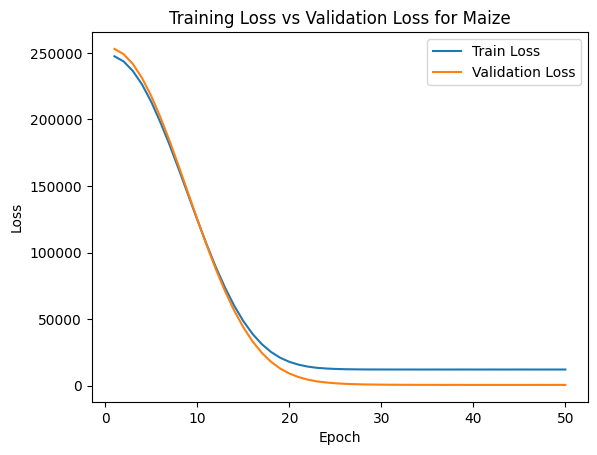

Maize Best Validation Model Loss: 497.3202
Maize Final Model RMSE: 31.8569



100%|██████████| 50/50 [01:22<00:00,  1.66s/it]


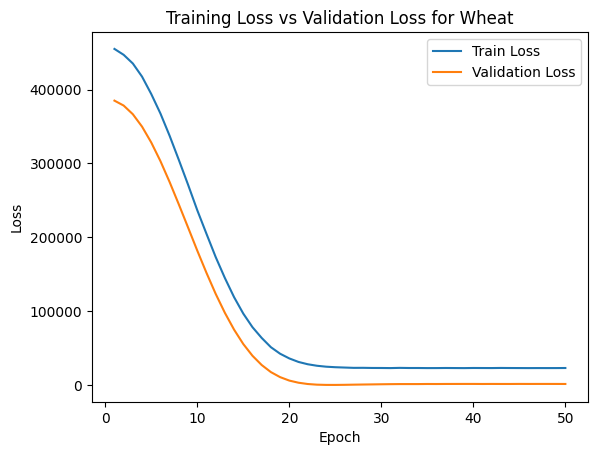

Wheat Best Validation Model Loss: 1835.1466
Wheat Final Model RMSE: 59.8629



100%|██████████| 50/50 [01:25<00:00,  1.72s/it]


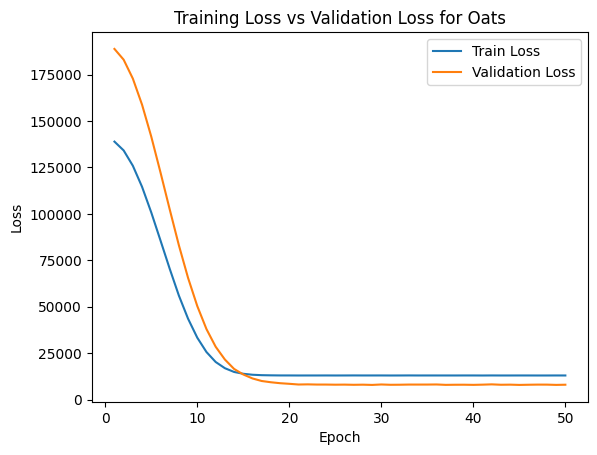

Oats Best Validation Model Loss: 8047.6082
Oats Final Model RMSE: 31.8021



100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


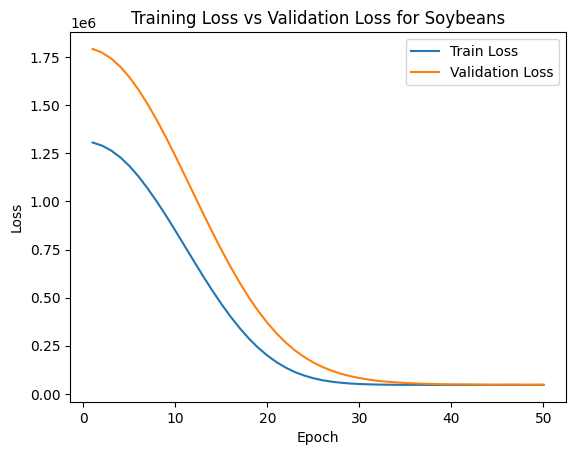

Soybeans Best Validation Model Loss: 47859.5059
Soybeans Final Model RMSE: 59.0312



In [11]:
eval_sequential_model(model_name='RNN', num_layers=NUM_LAYERS, hidden_size=BASE_HIDDEN_SIZE, extra_fc_layers=EXTRA_FC_LAYERS, 
                      lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True)

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


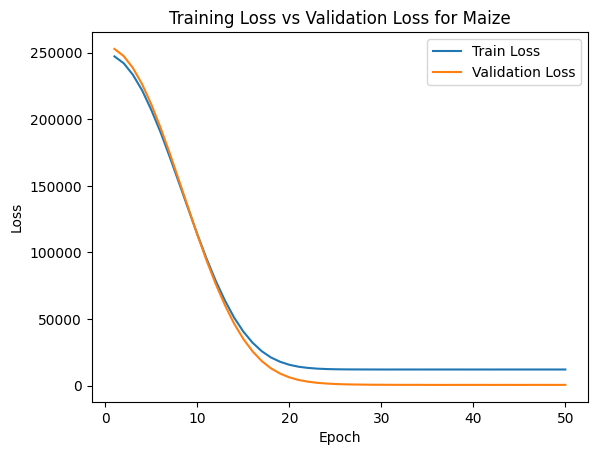

Maize Best Validation Model Loss: 521.0214
Maize Final Model RMSE: 31.5289



100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


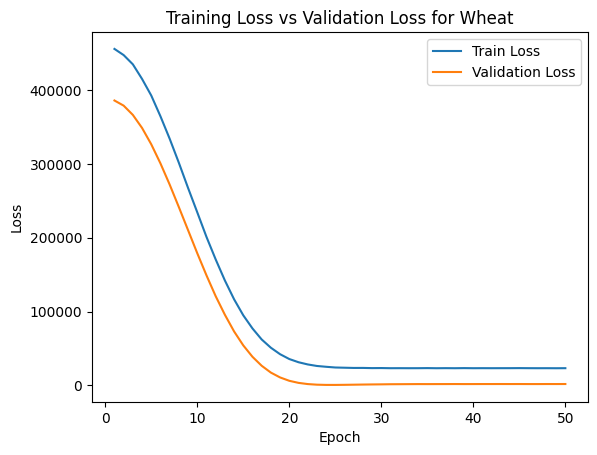

Wheat Best Validation Model Loss: 1920.4909
Wheat Final Model RMSE: 59.6972



100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


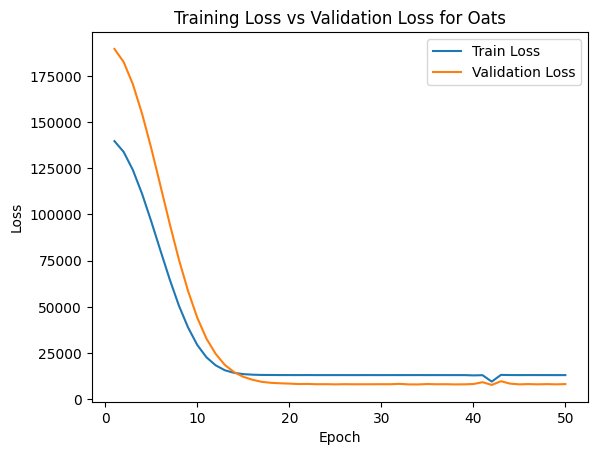

Oats Best Validation Model Loss: 8150.6255
Oats Final Model RMSE: 31.8042



100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


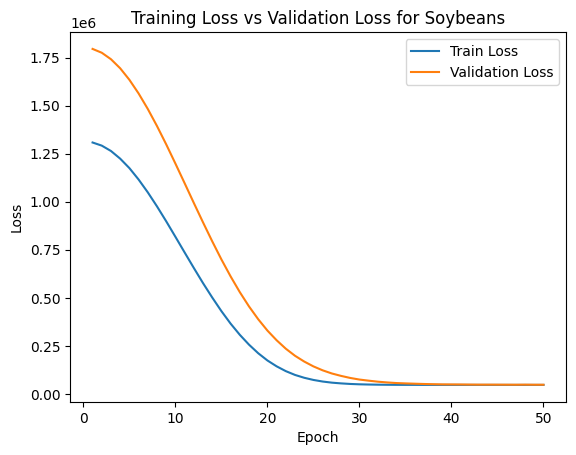

Soybeans Best Validation Model Loss: 47505.5488
Soybeans Final Model RMSE: 58.6074



In [12]:
eval_sequential_model(model_name='LSTM', num_layers=NUM_LAYERS, hidden_size=BASE_HIDDEN_SIZE, extra_fc_layers=EXTRA_FC_LAYERS, 
                      lr=LR, num_epochs=NUM_EPOCHS, calc_losses=True)